In [3]:
!pip install git+https://github.com/fujiisoup/pyspectra.git

import os
from os.path import join
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyspectra

data_path = join('/', 'Volumes', 'BUFFALO', 'SpectrometerData', '20201106')
print(os.path.exists(data_path))

  Cloning https://github.com/fujiisoup/pyspectra.git to /private/var/folders/ds/x3jwf2s54c3190fl2p4lrn3w0000gn/T/pip-req-build-y426756z
  Created wheel for pyspectra: filename=pyspectra-0.0.1-py3-none-any.whl size=18781 sha256=5d33cf607a6f89a0b55db6fd7f4ede7d8787d2de6c6e8ab9a2107aabb2f9bdca
  Stored in directory: /private/var/folders/ds/x3jwf2s54c3190fl2p4lrn3w0000gn/T/pip-ephem-wheel-cache-dyun2sut/wheels/f2/02/84/9d89f8a4f86fa15ea48ce7f528a8a47f07613ef90ab688594c
Successfully built pyspectra
True


In [4]:
file_names = [f'H_{430000 + 5000*i}.nc' for i in range(10)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

plasma_data = []
for i, p in enumerate(data['motor_coordinate']):
  d = data.sel(motor_coordinate=p).copy()
  d['long_x'] = d['x'][::-1] - 1000 * i
  d['x'] = data['x']
  plasma_data.append(d.sum('y'))
plasma_data = xr.concat(plasma_data, dim='motor_coordinate')

In [5]:
file_names = [f'back_{430000 + 5000*i}.nc' for i in range(10)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

back_data = []
for i, p in enumerate(data['motor_coordinate']):
    d = data.sel(motor_coordinate=p).copy()
    d['long_x'] = d['x'][::-1] - 1000 * i
    d['x'] = data['x']
    back_data.append(d.sum('y'))
back_data = xr.concat(back_data, dim='motor_coordinate')

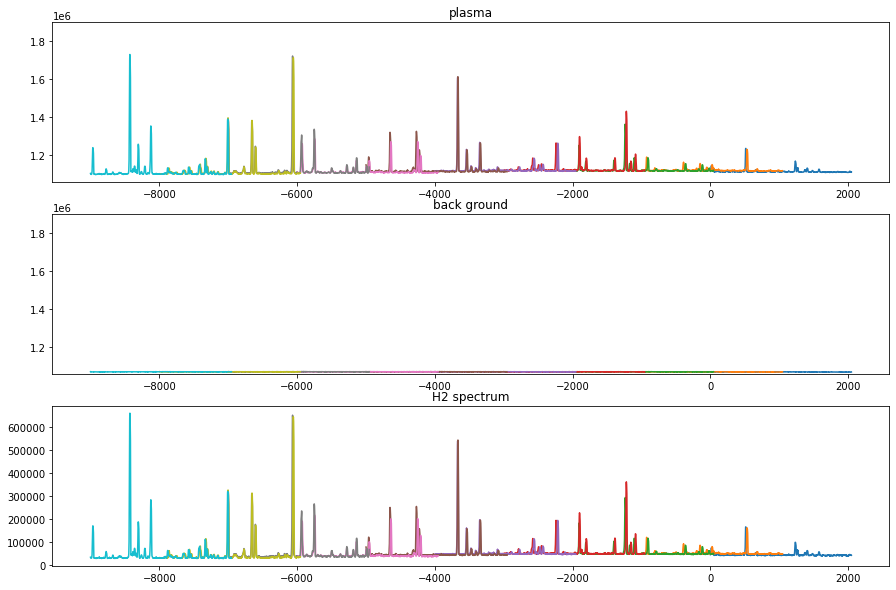

In [6]:
spectrum_data = plasma_data - back_data * 1.0

plt.figure(figsize=[15, 10])
plt.subplot(3, 1, 1)
plt.ylim(1.06*1e6, 1.9*1e6)
plt.title('plasma')
for f in plasma_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 2)
plt.title('back ground')
plt.ylim(1.06*1e6, 1.9*1e6)
for f in back_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 3)
plt.title('H2 spectrum')
for f in spectrum_data:
  plt.plot(f['long_x'], f)

## Q1

In [5]:
def fit(da):
  popt, perr = pyspectra.fit.singlepeak_fit(da['x'].values, da.values)
  return xr.Dataset({
      'A': popt[0], 'x0': popt[1], 'w': popt[2], 'y0': popt[3],
      'data': da,
      'fit': ('x', pyspectra.profiles.Gauss(da['x'].values, *popt))},
      coords={'x': da['x']})

Text(-7230, 100000, 'N=6')

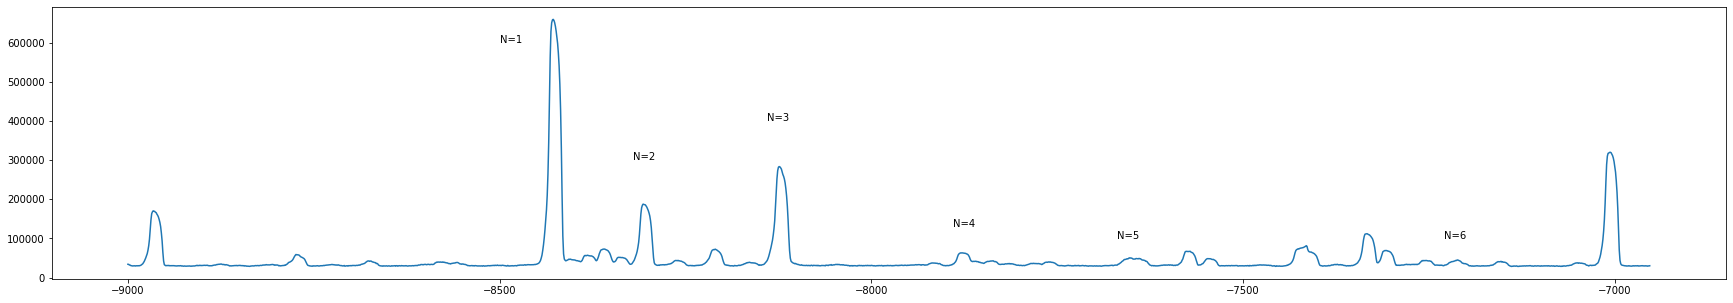

In [6]:
plt.figure(figsize=(30, 5))
plt.plot(spectrum_data[9]['long_x'], spectrum_data[9])
plt.text(-8500, 600000, 'N=1')
plt.text(-8320, 300000, 'N=2')
plt.text(-8140, 400000, 'N=3')
plt.text(-7890, 130000, 'N=4')
plt.text(-7670, 100000, 'N=5')
plt.text(-7230, 100000, 'N=6')
#plt.plot(spectrum_data[9]['x'], spectrum_data[9])
#plt.xlim(200, 600)
#plt.ylim(-5000, 200000)

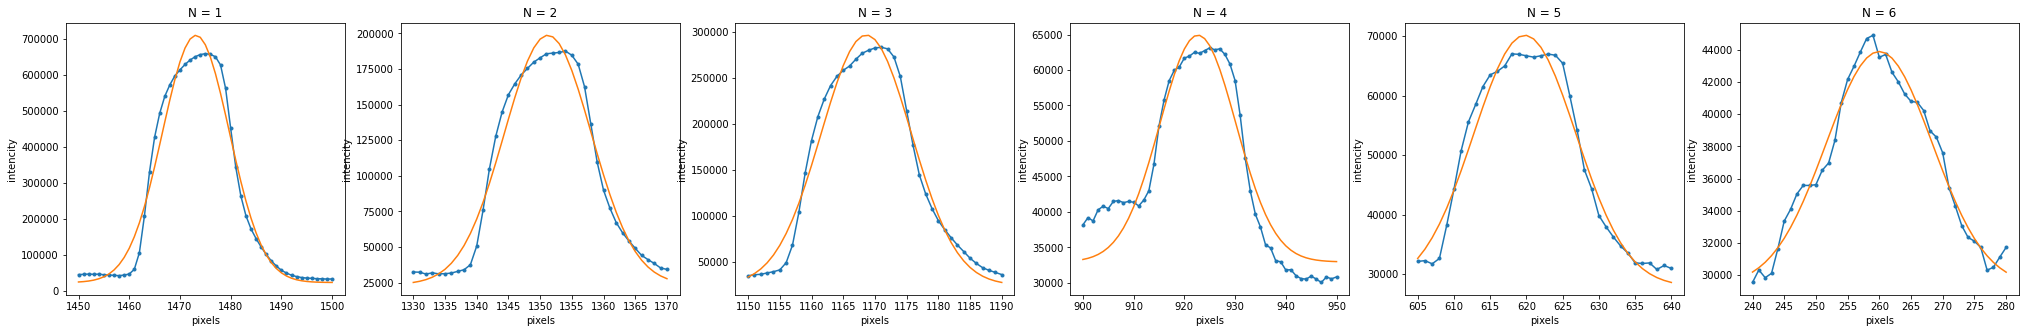

In [7]:
spectrum_lims = [
  [1450, 1500],
  [1330, 1370],
  [1150, 1190],
  [900, 950],
  [605, 640],
  [240, 280]
]
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
  610.9030
]
plt.figure(figsize=(35, 5))
Q1_result = []

for i, lims in enumerate(spectrum_lims):
  result = fit(spectrum_data.sel(motor_coordinate=475000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
  result['v'] = 0
  result['N'] = i+1
  result['wave_length'] = wave_lengths[i]
  plt.subplot(1, len(spectrum_lims), i+1)
  result['data'].plot(marker='.')
  result['fit'].plot()
  plt.title('N = {}'.format(i+1))
  plt.xlabel('pixels')
  plt.ylabel('intencity')
  Q1_result.append(result)
Q1_result = xr.concat(Q1_result, dim='N')

Text(0, 0.5, 'area')

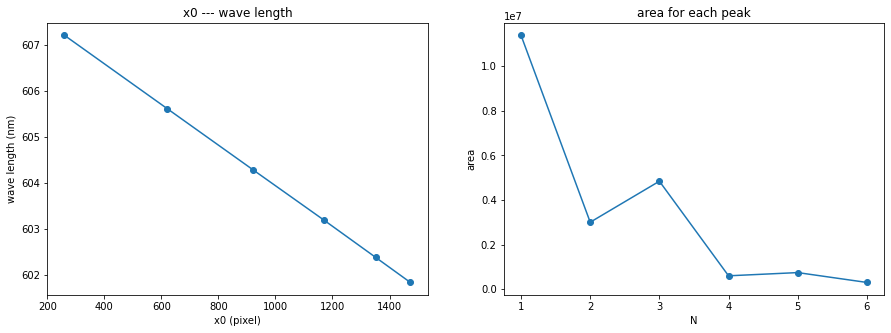

In [8]:
#for i, re in enumerate(Q1_result['x0']):
#  print(spectrum_data.sel(motor_coordinate=475000).isel(x=int(re[i]))['long_x'])
#print(spectrum_data.sel(motor_coordinate=475000).isel(x=int(Q1_result['x0'][0]))['long_x'])

plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
plt.plot(Q1_result['x0'], Q1_result['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')
plt.subplot(1, 2, 2)
plt.plot(Q1_result['N'], Q1_result['A'], marker='o')
plt.title('area for each peak')
plt.xlabel('N')
plt.ylabel('area')

# Q2

(-5000.0, 200000.0)

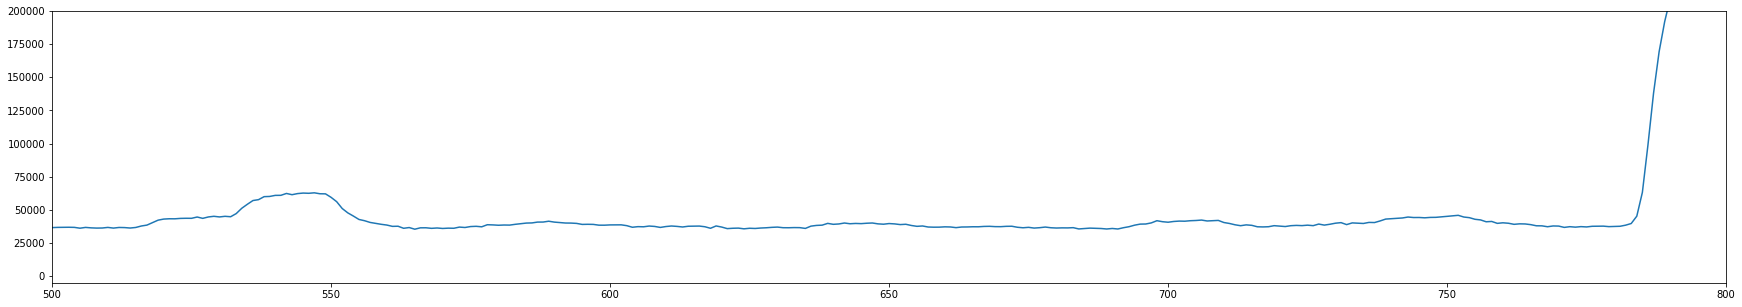

In [9]:
plt.figure(figsize=(30, 5))
#plt.plot(spectrum_data[7]['long_x'], spectrum_data[9])
#plt.text(-8500, 600000, 'N=1')
#plt.text(-8320, 300000, 'N=2')
#plt.text(-8140, 400000, 'N=3')
#plt.text(-7890, 130000, 'N=4')
#plt.text(-7670, 100000, 'N=5')
#plt.text(-7230, 100000, 'N=6')
plt.plot(spectrum_data[7]['x'], spectrum_data[7])
plt.xlim(500, 800)
plt.ylim(-5000, 200000)

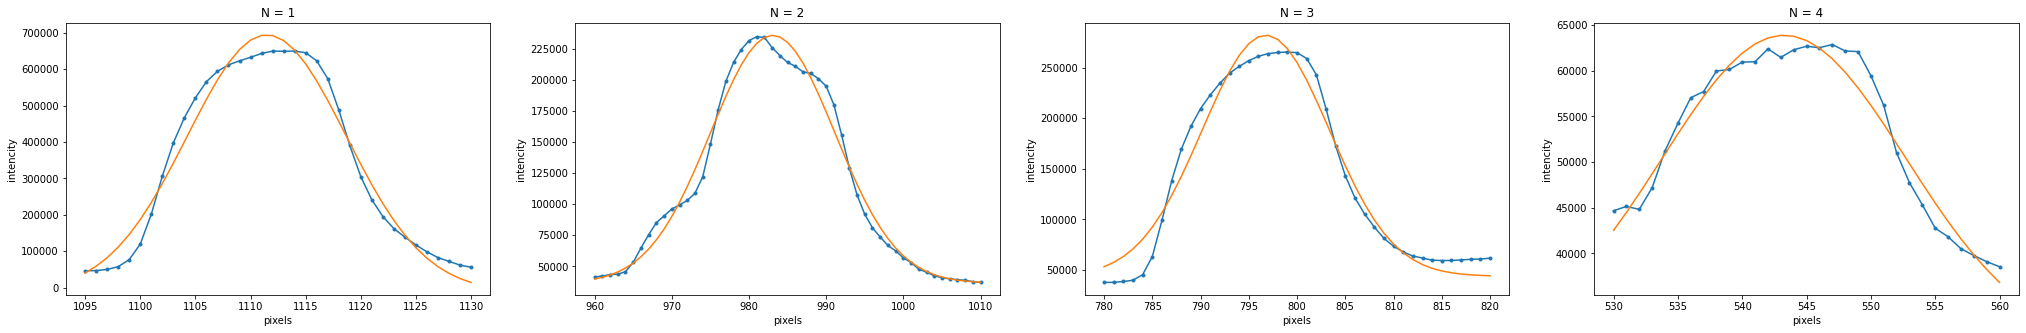

In [10]:
spectrum_lims = [
  [1095, 1130],
  [960, 1010],
  [780, 820],
  [530, 560],
#  [605, 640],
#  [240, 280]
]
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565

]
plt.figure(figsize=(35, 5))
Q2_result = []

for i, lims in enumerate(spectrum_lims):
  result = fit(spectrum_data.sel(motor_coordinate=465000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
  result['v'] = 1
  result['N'] = i+1
  result['wave_length'] = wave_lengths[i]
  plt.subplot(1, len(spectrum_lims), i+1)
  result['data'].plot(marker='.')
  result['fit'].plot()
  plt.title('N = {}'.format(i+1))
  plt.xlabel('pixels')
  plt.ylabel('intencity')
  Q2_result.append(result)
Q2_result = xr.concat(Q2_result, dim='N')

Text(0, 0.5, 'area')

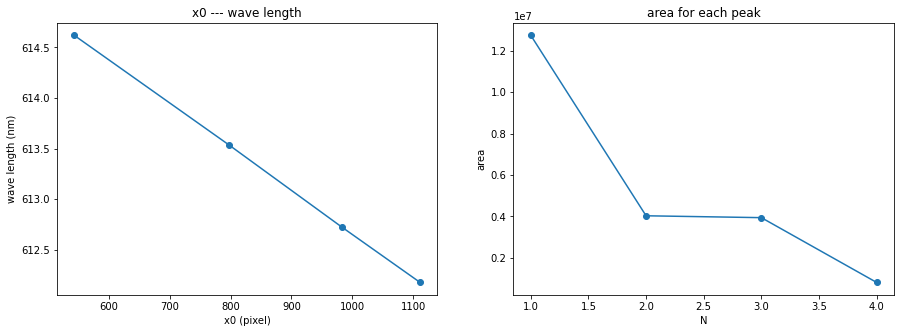

In [11]:
plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
plt.plot(Q2_result['x0'], Q2_result['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')
plt.subplot(1, 2, 2)
plt.plot(Q2_result['N'], Q2_result['A'], marker='o')
plt.title('area for each peak')
plt.xlabel('N')
plt.ylabel('area')

In [12]:
# d状態の回転エネルギー
def e_rot(v, N):
  return (30.364-1.545*(v+1/2))*N*(N+1)-0.0191*N*(N+1)*N*(N+1)

# 核スピンの縮退度(核スピンの統計重率)
def g_as(N):
  return (N % 2) * 2 + 1

# 回転の統計重率(もしかしたら二乗じゃ無いかも)
def g_N(N):
  return (2*N+1)*(2*N+1)

Text(0.5, 1.0, 'upper enegy -- population')

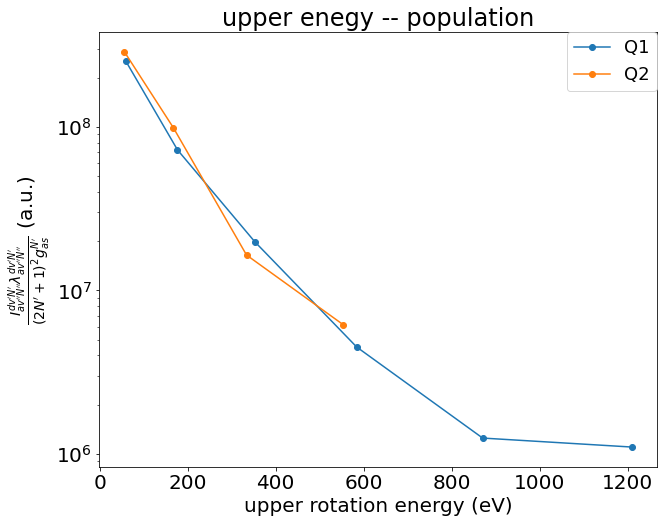

In [15]:
plt.figure(figsize=[10, 8])
plt.rcParams['font.size'] = 20

Q1_population = Q1_result['A'] * Q1_result['wave_length'] / g_N(Q1_result['N']) / g_as(Q1_result['N'])
Q2_population = Q2_result['A'] * Q2_result['wave_length'] / g_N(Q2_result['N']) / g_as(Q2_result['N'])

plt.yscale('log')

plt.semilogy(e_rot(Q1_result['v'], Q1_result['N']), Q1_population, '-o', label='Q1')
plt.semilogy(e_rot(Q2_result['v'], Q2_result['N']), Q2_population, '-o', label='Q2')
#plt.semilogy(e_rot(Q3_result['v'], Q3_result['N']), Q3_population, '-o')

plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18)
plt.xlabel('upper rotation energy (eV)')
plt.ylabel(r"$\frac{I^{dv'N'}_{av''N''}\lambda^{dv'N'}_{av''N''}}{(2N'+1)^2g^{N'}_{as}}$ (a.u.)")
plt.title('upper enegy -- population')